In [1]:
# Make own packages auto reload
%load_ext autoreload
%autoreload 2

# Mosaics

In [2]:
from plot import plot_mosaics
from simulate import simulate_rgc_mosaics

n_mosaics = 3
center_noise = 0.1  # Position noise
diameter_noise = 0.1

mean_diameters = [10., 12.0, 15.0]  # Mean diameter for each mosaic
n_missing_list = [0, 0, 0]  # Missing cells per mosaic
overlap_factors = [1.1, 1.1, 1.1]  # No overlap, 15% overlap, 10% gaps

# Generate mosaics
groups, polygons, centers, clipped = simulate_rgc_mosaics(
    n_mosaics=n_mosaics,
    mean_diameters=mean_diameters,
    center_noise=center_noise,
    diameter_noise=diameter_noise,
    n_missing_list=n_missing_list,
    overlap_factors=overlap_factors,
)

In [3]:
from overlap import compute_iou_matrix

iou_matrix = compute_iou_matrix(polygons)

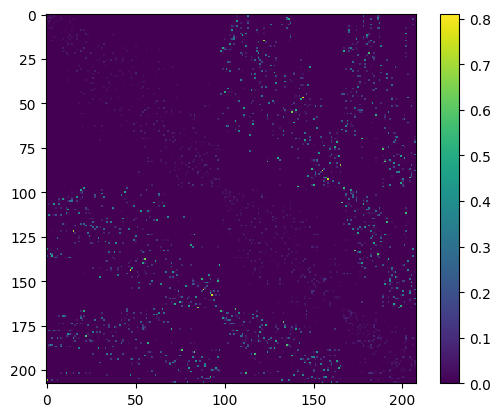

In [4]:
from matplotlib import pyplot as plt

plt.imshow(iou_matrix, interpolation='none')
plt.colorbar()
plt.show()

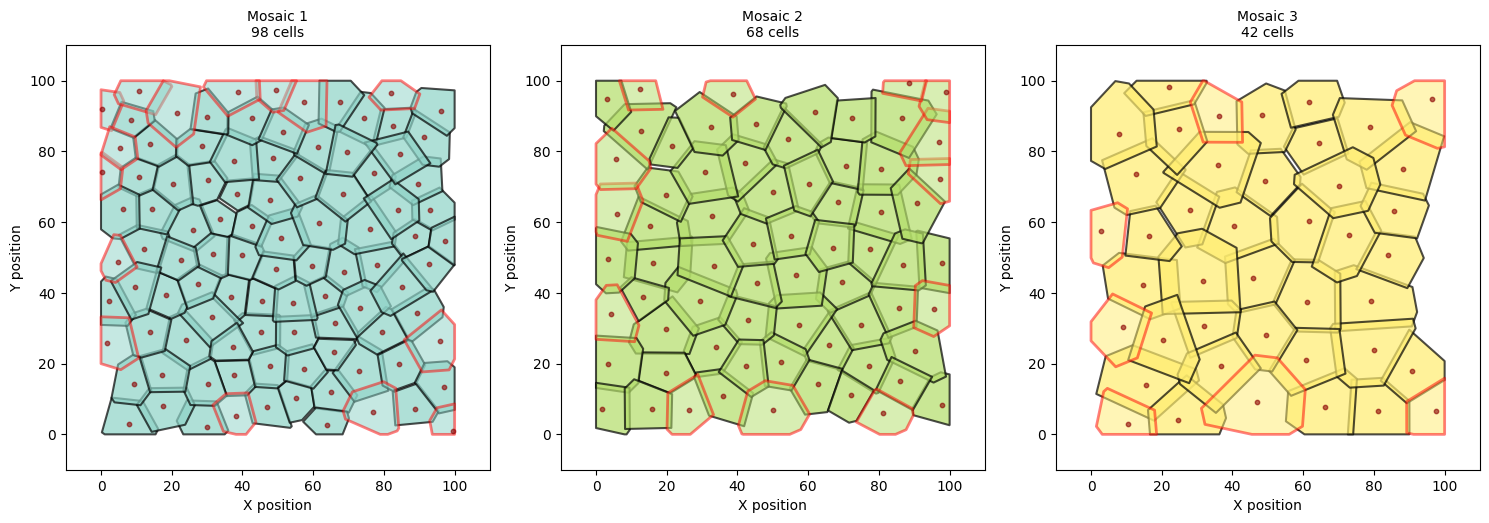

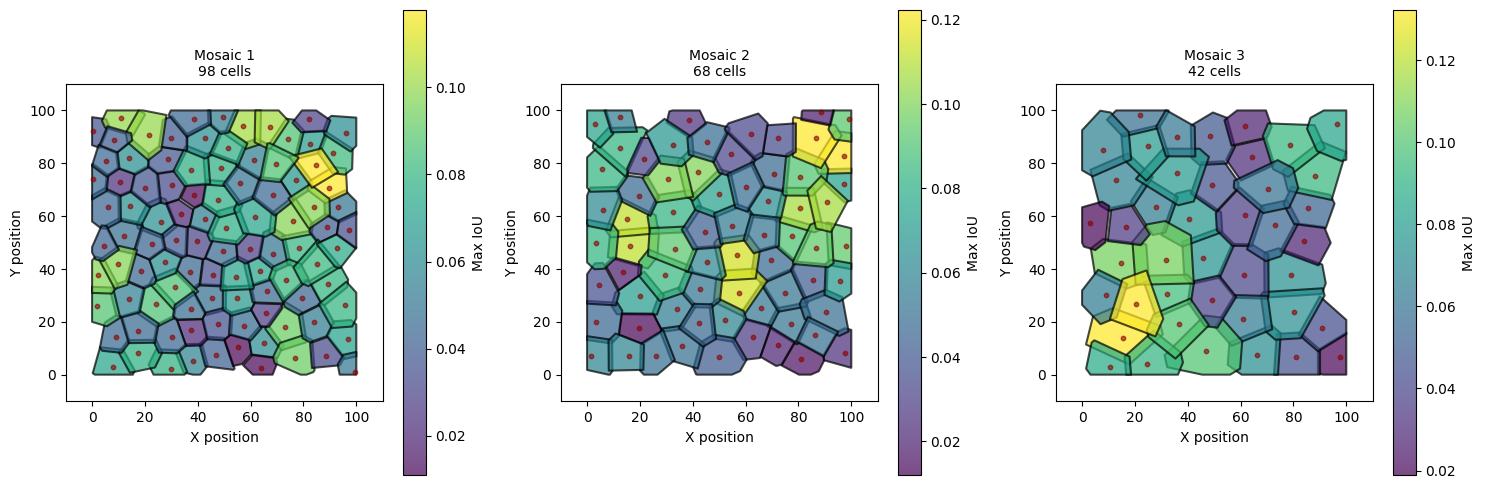

In [5]:
from matplotlib import pyplot as plt

plot_mosaics(groups, polygons, centers, highlight=clipped, mode='basic')
plt.show()

plot_mosaics(groups, polygons, centers, iou_matrix=iou_matrix, highlight=clipped, mode='iou')
plt.show()

# Features

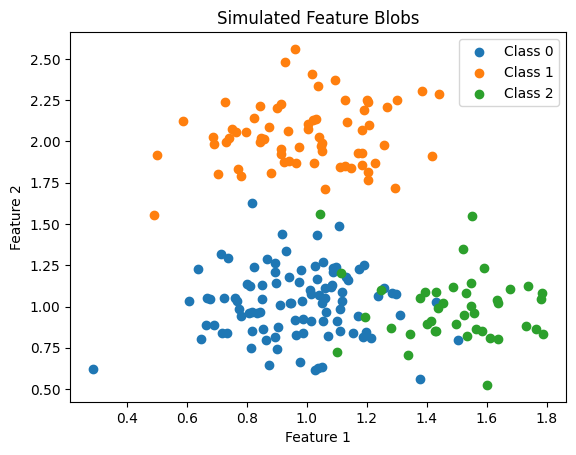

In [6]:
from plot import plot_blobs
from matplotlib import pyplot as plt
import numpy as np

u_groups, n_per_group = np.unique(groups, return_counts=True)
n_groups = len(u_groups)

assert n_groups == 3

feat_centers = [
    (1, 1),
    (1, 2),
    (1.5, 1),
]

feat_stds = [
    (0.2, 0.2),
    (0.2, 0.2),
    (0.2, 0.2),
]

X = []
y = []
for i, n_i in enumerate(n_per_group):
    center_i = feat_centers[i]
    stds_i = feat_stds[i]
    X_i = np.random.normal(center_i, stds_i, size=(n_i, 2))
    X.append(X_i)
    y.append(np.full(n_i, i))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

plot_blobs(X=X, y=y)

In [7]:
import scanpy as sc

adata = sc.AnnData(X)
sc.pp.scale(adata)
sc.pp.neighbors(adata, n_neighbors=5, use_rep='X')

# Connectivities

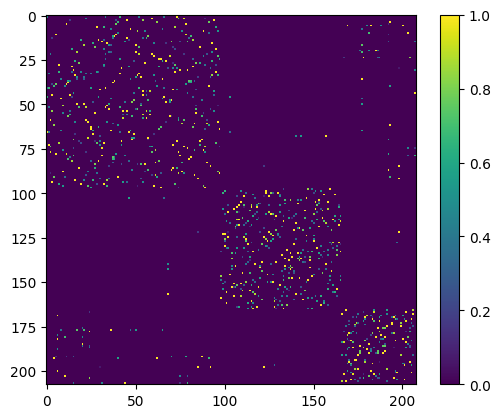

In [8]:
plt.imshow(adata.obsp['connectivities'].toarray(), interpolation='none')
plt.colorbar()
plt.show()

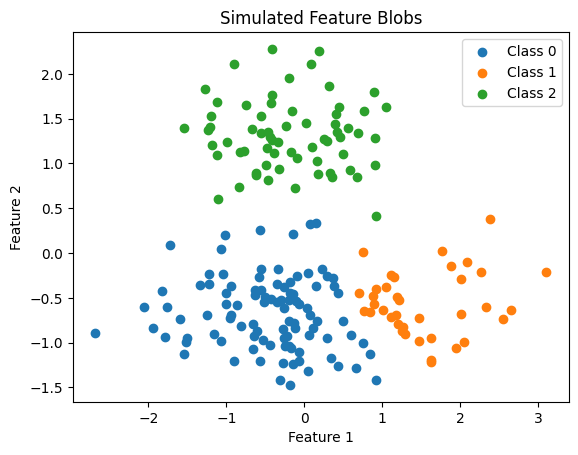

In [87]:
from clustering import find_leiden_resolution

leiden_res = find_leiden_resolution(
    adata, n_groups, adjacency_key='connectivities', key_added='leiden',
    start_res=1, tolerance=0, max_iter=20, verbose=False
)
plot_blobs(X=X, y=adata.obs["leiden"])
plt.show()

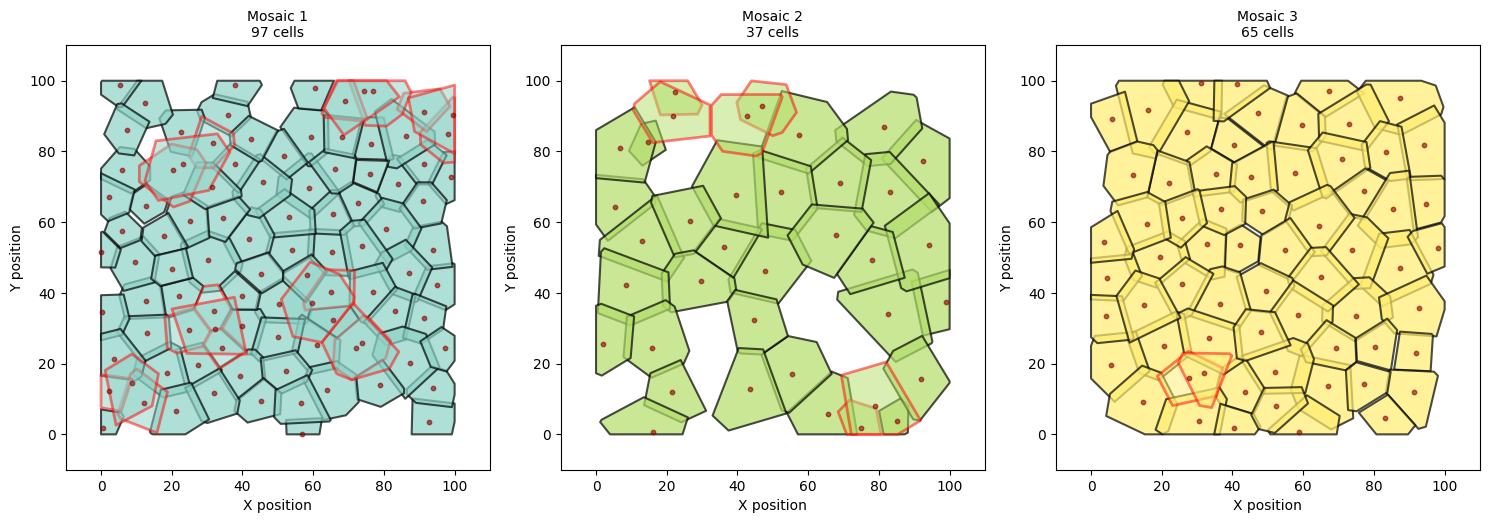

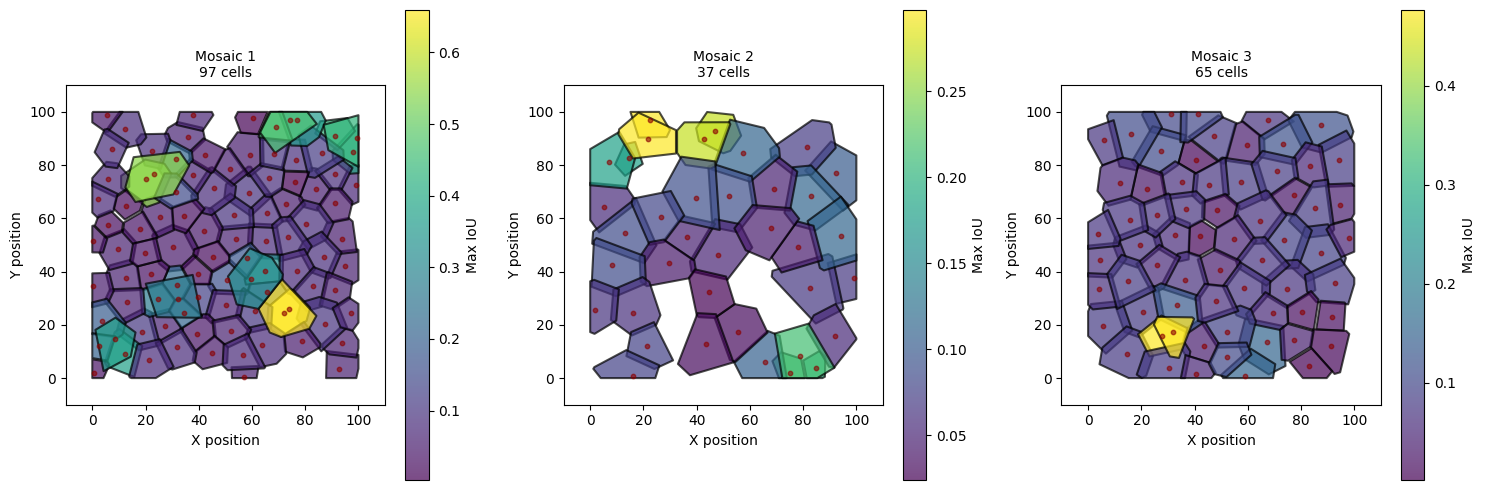

In [88]:
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='violations', iou_matrix=iou_matrix, iou_threshold=0.2)
plt.show()
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

In [115]:
from clustering import apply_mosaic_constraints

repel_threshold = 0.3

# 2. Apply spatial mosaic penalty
adata = apply_mosaic_constraints(
    adata,
    iou_matrix,
    attract_threshold=0.15,
    repel_threshold=repel_threshold,
    attract_weight=2,
    repel_weight=2,
    mode='multiply',
)

In [116]:
diff = adata.obsp['connectivities'].toarray() - adata.obsp['mosaic_connectivities'].toarray()

(diff > 0).sum() / (diff == 0).sum()

np.float64(0.0263328408884742)

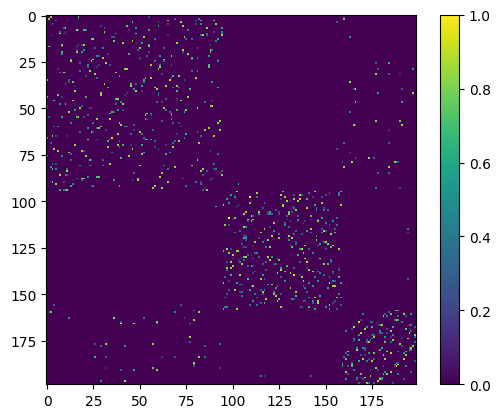

In [117]:
plt.imshow(adata.obsp['mosaic_connectivities'].toarray(), interpolation='none')
plt.colorbar()
plt.show()

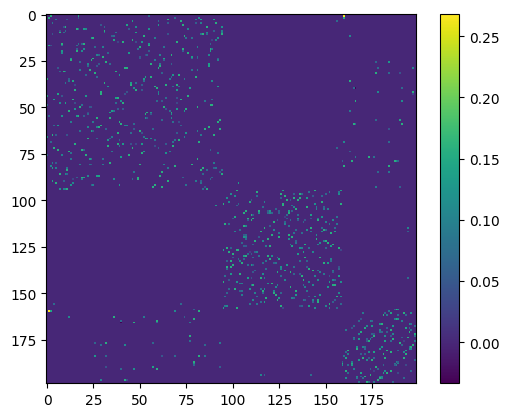

In [118]:
plt.imshow(diff, interpolation='none')
plt.colorbar()
plt.show()

In [119]:
from clustering import find_leiden_resolution

find_leiden_resolution(
    adata, n_groups, adjacency_key='mosaic_connectivities', key_added='leiden_mosaic',
    start_res=leiden_res, tolerance=0, max_iter=20, verbose=False
);

In [120]:
adata.obs["leiden_mosaic"].unique()

['0', '1', '2']
Categories (3, object): ['0', '1', '2']

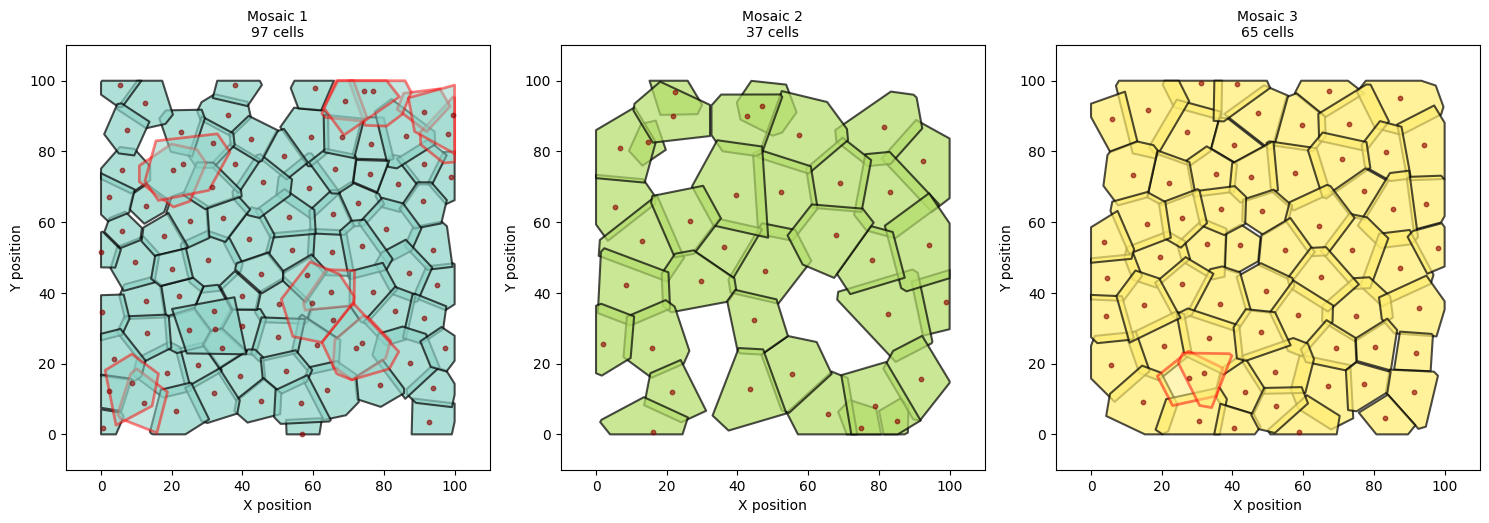

In [121]:
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='violations', iou_matrix=iou_matrix,
             iou_threshold=repel_threshold)
plt.show()

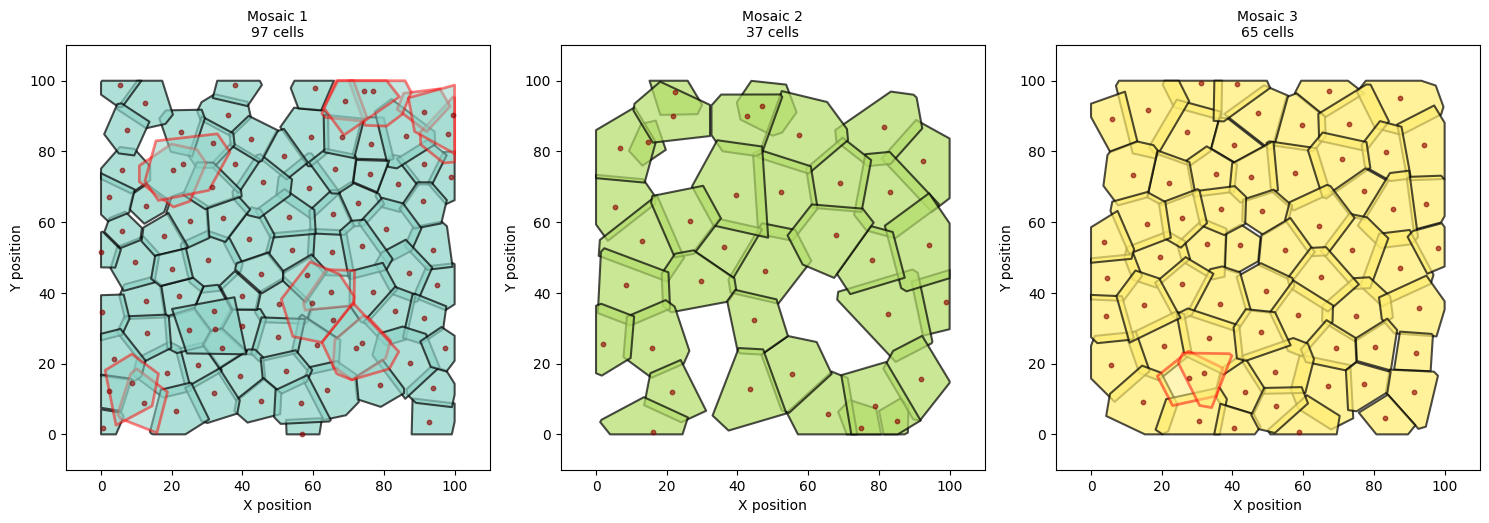

In [122]:
plot_mosaics(adata.obs["leiden_mosaic"], polygons, centers, mode='violations', iou_matrix=iou_matrix,
             iou_threshold=repel_threshold)
plt.show()

In [123]:
from clustering import compare_clustering_mosaic_quality

# 5. Compare mosaic quality
comparison = compare_clustering_mosaic_quality(
    adata,
    iou_matrix,
    standard_key='leiden',
    mosaic_key='leiden_mosaic',
    iou_threshold=repel_threshold,
)

print("\nMosaic Quality Comparison:")
print(comparison.groupby('method')[['mean_iou', 'max_iou', 'violations']].mean())


Mosaic Quality Comparison:
              mean_iou   max_iou  violations
method                                      
Mosaic-aware  0.051118  0.477542         3.0
Standard      0.051118  0.477542         3.0


# Constrained leiden

In [17]:
from constrained_leidenalg import build_spatial_feature_graph, find_optimal_resolution, spatially_constrained_leiden, \
    post_process_enforce_contiguity, SpatialLeidenPartition

features = X
positions = centers

G = build_spatial_feature_graph(positions, features)

opt_kws = dict(
    overlap_threshold=0.2,
    overlap_penalty=1000.0,
    require_adjacency=False,
    n_iterations=10,
    seed=42
)

optimal_res = find_optimal_resolution(
    G, positions, target_clusters=(3, 3),
    partition_type=SpatialLeidenPartition,
    resolutions=np.linspace(0.1, 1, 15),
    verbose=True, **opt_kws)

# Run spatially-constrained Leiden
clusters, partition = spatially_constrained_leiden(
    G,
    positions,
    partition_type=SpatialLeidenPartition,
    **opt_kws,
    resolution_parameter=optimal_res,
)

print(f"\nFinal result: {len(np.unique(clusters))} clusters")
cluster_sizes = np.bincount(clusters)
print(f"Cluster sizes: min={cluster_sizes[cluster_sizes > 0].min()}, "
      f"max={cluster_sizes.max()}, "
      f"mean={cluster_sizes[cluster_sizes > 0].mean():.1f}")

# Optional: post-process to ensure contiguity
clusters_clean = post_process_enforce_contiguity(clusters, positions)
print(f"After contiguity enforcement: {len(np.unique(clusters_clean))} clusters")

Searching for resolution to get 3-3 clusters...
Starting spatially-constrained Leiden clustering...
  Resolution parameter: 0.1
  Overlap threshold: 0.2
  Overlap penalty: 1000.0
  Require adjacency: False
  Running optimization...
Optimization complete:
  Final clusters: 2
  Resolution 0.10 -> 2 clusters
Starting spatially-constrained Leiden clustering...
  Resolution parameter: 0.1642857142857143
  Overlap threshold: 0.2
  Overlap penalty: 1000.0
  Require adjacency: False
  Running optimization...
Optimization complete:
  Final clusters: 3
  Resolution 0.16 -> 3 clusters

✓ Found good resolution: 0.16 gives 3 clusters

Final result: 3 clusters
Cluster sizes: min=61, max=80, mean=69.3
After contiguity enforcement: 3 clusters


In [18]:
clusters_clean

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1,
       0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0,
       1, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1,
       2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 2, 1, 1, 2, 0, 0, 2, 0, 0, 2, 2,
       0, 2, 0, 1, 1, 1, 2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 2, 0,
       0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 0,
       0, 2, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 2, 2, 2, 1, 0, 2, 0, 1, 0])

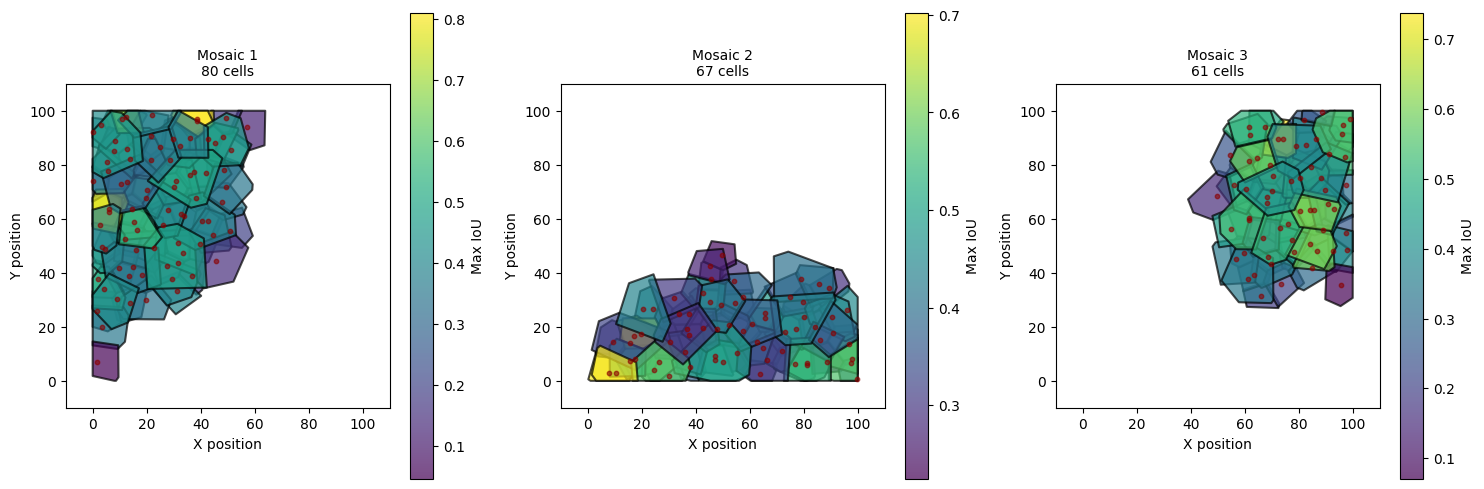

In [19]:
plot_mosaics(clusters_clean, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# Mosaic leiden

In [1]:
from constrained_leidenalg import build_feature_knn_graph, tune_mosaic_parameters, MosaicLeidenPartition

print("Building feature-based kNN graph...")
G = build_feature_knn_graph(features, k=15)

tuning_results = tune_mosaic_parameters(
    G, positions,
    partition_type=MosaicLeidenPartition,
    radius_range=[10, 15, 20],
    res_range=[1.0, 1.2]
)

# best_run = tuning_results.sort_values(by='ri', ascending=False).iloc[0]
#
# print(f"\nOptimal Parameters Found:")
# print(f" > Radius: {best_run['radius']}")
# print(f" > Resolution: {best_run['resolution']}")
# print(f" > Resulting RI: {best_run['ri']:.3f}")

# 5. Final Optimized Run
# ---------------------------------------------------------
final_clusters, partition = spatially_constrained_leiden(
    G, positions,
    partition_type=MosaicLeidenPartition,
    territory_radius=10,#best_run['radius'],
    resolution_parameter=0.5,#best_run['resolution'],
    overlap_penalty=2.0,  # Higher penalty for the final run
    n_iterations=10
)

# 6. Final Clean up and Output
# ---------------------------------------------------------
# Ensure each "color" (cluster) is a single connected mosaic
final_clusters = post_process_enforce_contiguity(final_clusters, positions)

print(f"\nFinal Mosaic Count: {len(np.unique(final_clusters))}")

Building feature-based kNN graph...


NameError: name 'features' is not defined